## Implementing VQE

Executing a VQE algorithm requires these three steps:

Setting up the Hamiltonian and ansatz (problem specification)

Implementing the Qiskit Runtime estimator

Adding the Classical optimizer and running our program

### Random operator measuring spins 

In [2]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
# plt.style.use('dark_background')
from qiskit_ibm_runtime import QiskitRuntimeService

In [7]:
# service = QiskitRuntimeService()
# backend = service.least_busy(simulator=False)

In [8]:
# backend.name

'ibm_osaka'

In [ ]:
# print(backend.configuration().processor_type)
# print(backend.configuration().supported_instructions)

In [3]:

pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(pauli_op.to_matrix())

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


**create a ansats**

-> either could be a TwoLocal circuit (  pre-built circuit that can be used to prepare trial wave functions for variational quantum algorithms)

-> Or EfficientSu2 ansatz ( said to be hardware efficient) 

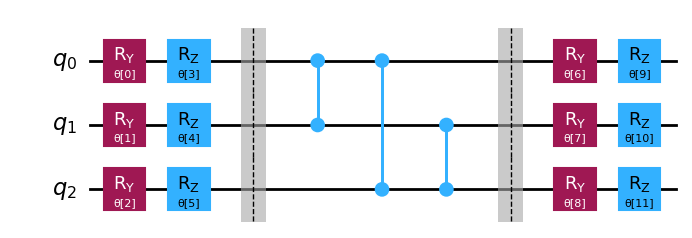

In [4]:
num_qubits = 3
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cz'
entanglement = 'full'

ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks,entanglement,reps=1,insert_barriers=True)
ansatz.decompose().draw('mpl')

In [5]:
num_params = ansatz.num_parameters
num_params

12

In [9]:
backend = FakeSherbrooke()
optimization_level_answer = 1
pm = generate_preset_pass_manager(backend=backend,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)

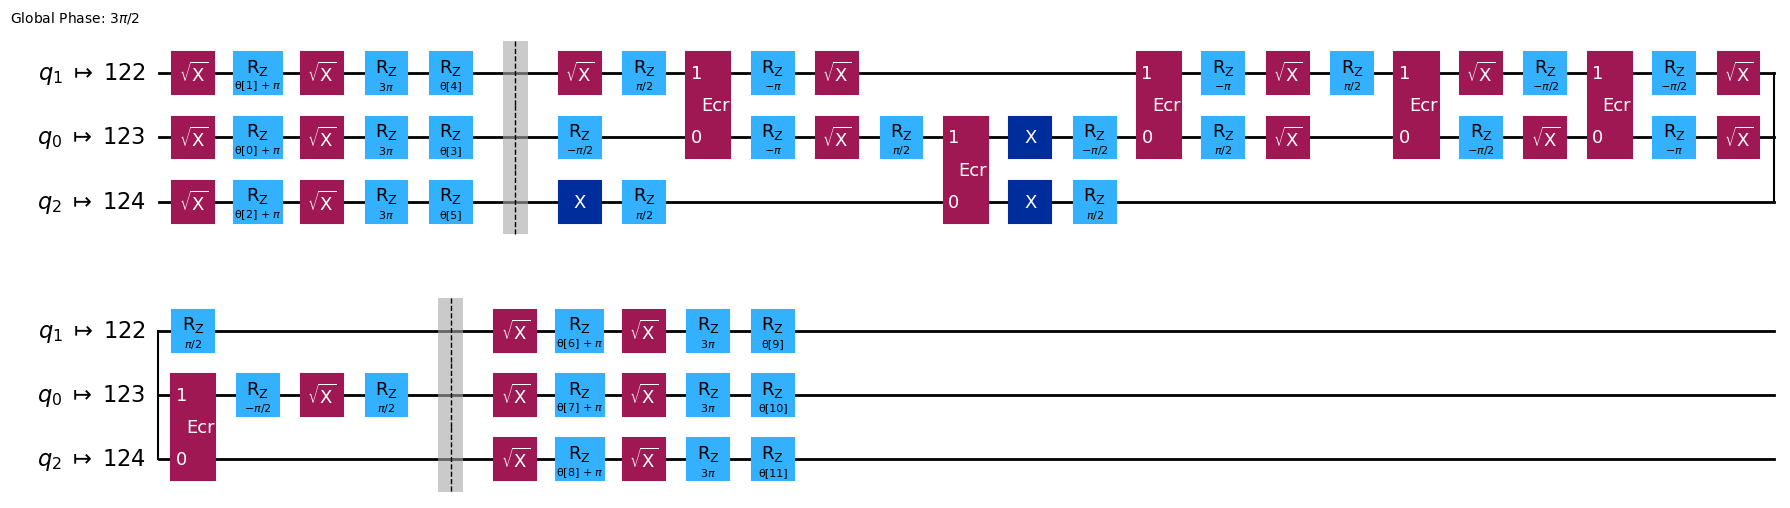

In [10]:
isa_circuit.draw('mpl', idle_wires=False)


In [11]:
# Define our Hamiltonian
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz,[hamiltonian],[params]) #(circuit, observables, parameter_values)
    result = estimator.run(pubs= [pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)


### Don't change any code past this line ###
    print(energy)
    return energy, result

In [13]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}



In [14]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([0.97269481, 5.02844894, 3.21607387, 0.63392516, 2.67161147,
       2.43450817, 5.86811709, 2.61945115, 0.47573618, 4.62715753,
       5.75631212, 2.53323979])

In [15]:


# backend = FakeSherbrooke()
# backend = AerSimulator()


def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 100})

E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


-0.4765625
-1.73876953125
-2.287109375
-1.59423828125
-1.99658203125
-2.29541015625
-2.30712890625
-1.634765625
-2.2568359375
-1.5380859375
-2.357421875
-2.32275390625
-2.2978515625
-2.62158203125
-2.02490234375
-2.416015625
-2.416015625
-2.41943359375
-2.70556640625
-2.58837890625
-2.70751953125
-2.7099609375
-2.68896484375
-2.35498046875
-2.73486328125
-2.66259765625
-2.7548828125
-2.8271484375
-2.75732421875
-2.81494140625
-2.78955078125
-2.8134765625
-2.86376953125
-2.85205078125
-2.86181640625
-2.8466796875
-2.8056640625
-2.849609375
-2.84228515625
-2.82958984375
-2.837890625
-2.82958984375
-2.83251953125
-2.84326171875
-2.8486328125
-2.86474609375
-2.83349609375
-2.8466796875
-2.822265625
-2.85205078125
-2.8505859375
-2.83349609375
-2.8447265625
-2.8740234375
-2.8427734375
-2.8408203125
-2.84814453125
-2.8349609375
-2.841796875
-2.8515625
-2.85400390625
-2.84619140625
-2.8525390625
-2.841796875
-2.83935546875
-2.85986328125
-2.83642578125
-2.8388671875
-2.84912109375
-2.858398437

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='fd6125b5c49d263b565801afa33551c6ee1b6140d64d12cfa55fc77d8f030ed160c312d6743e1758babe4a62f0f573911fc5c39a5d219dc68c377cd42d08a7b3'
)
job = service.job('csxar89sgar0008d49hg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [1.74484132]


In [16]:
# job.inputs['circuit'][0]

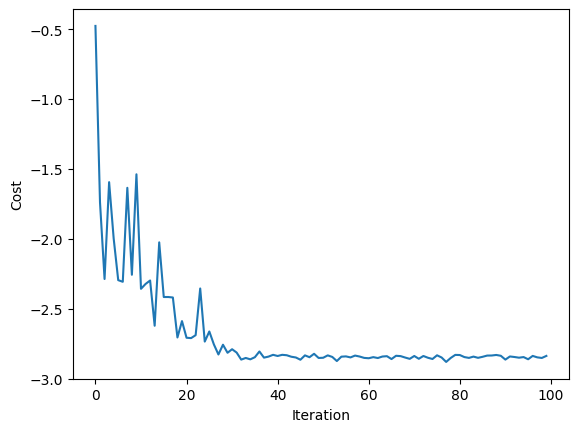

In [17]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.draw()

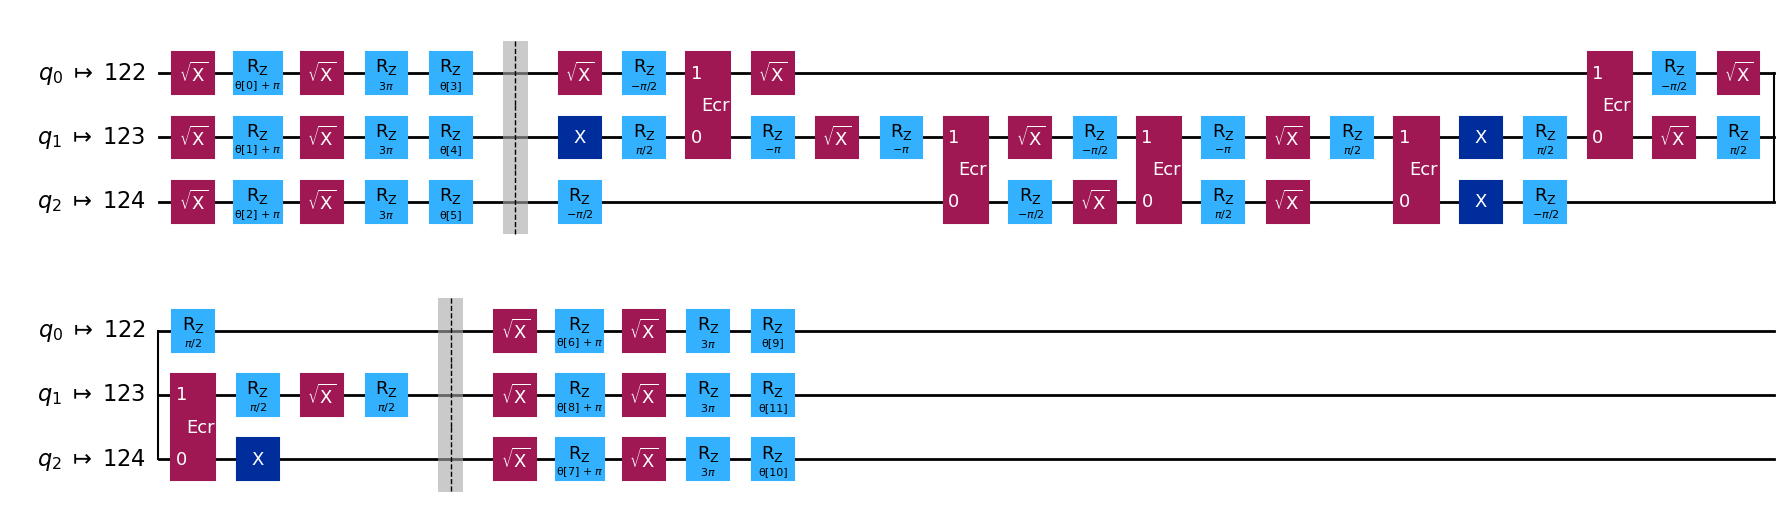

In [14]:
isa_circuit.draw('mpl', idle_wires=False)

In [15]:
callback_dict

{'prev_vector': array([5.79068996, 3.16247396, 3.15351397, 6.07748056, 4.58295589,
        1.32581645, 3.69881844, 6.28662102, 0.05610725, 0.42635626,
        0.05853192, 3.90607227]),
 'iters': 100,
 'cost_history': [-0.3837890625,
  -1.17431640625,
  -0.21533203125,
  -1.76611328125,
  -1.7001953125,
  -1.79248046875,
  -1.7880859375,
  -1.7490234375,
  -1.5380859375,
  -0.876953125,
  -1.71044921875,
  -1.76416015625,
  -1.78955078125,
  -2.77197265625,
  -2.54736328125,
  -2.39892578125,
  -2.77392578125,
  -2.7607421875,
  -2.67333984375,
  -2.609375,
  -2.75830078125,
  -2.744140625,
  -2.740234375,
  -2.7626953125,
  -2.759765625,
  -2.767578125,
  -2.73486328125,
  -2.6796875,
  -2.9580078125,
  -2.86328125,
  -2.93798828125,
  -2.89794921875,
  -2.8828125,
  -2.94140625,
  -2.91845703125,
  -2.93212890625,
  -2.95068359375,
  -2.92138671875,
  -2.97021484375,
  -2.970703125,
  -2.95458984375,
  -2.95751953125,
  -2.97265625,
  -2.98828125,
  -2.984375,
  -2.95263671875,
  -2.9

In [16]:
print(res)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.99462890625
       x: [ 5.791e+00  3.162e+00  3.153e+00  6.077e+00  4.583e+00
            1.326e+00  3.699e+00  6.287e+00  5.591e-02  4.265e-01
            5.845e-02  3.906e+00]
    nfev: 100
   maxcv: 0.0


In [17]:
isa_circuit.depth()

33

In [18]:
isa_circuit.count_ops()

OrderedDict([('rz', 35), ('sx', 22), ('ecr', 6), ('x', 4), ('barrier', 2)])

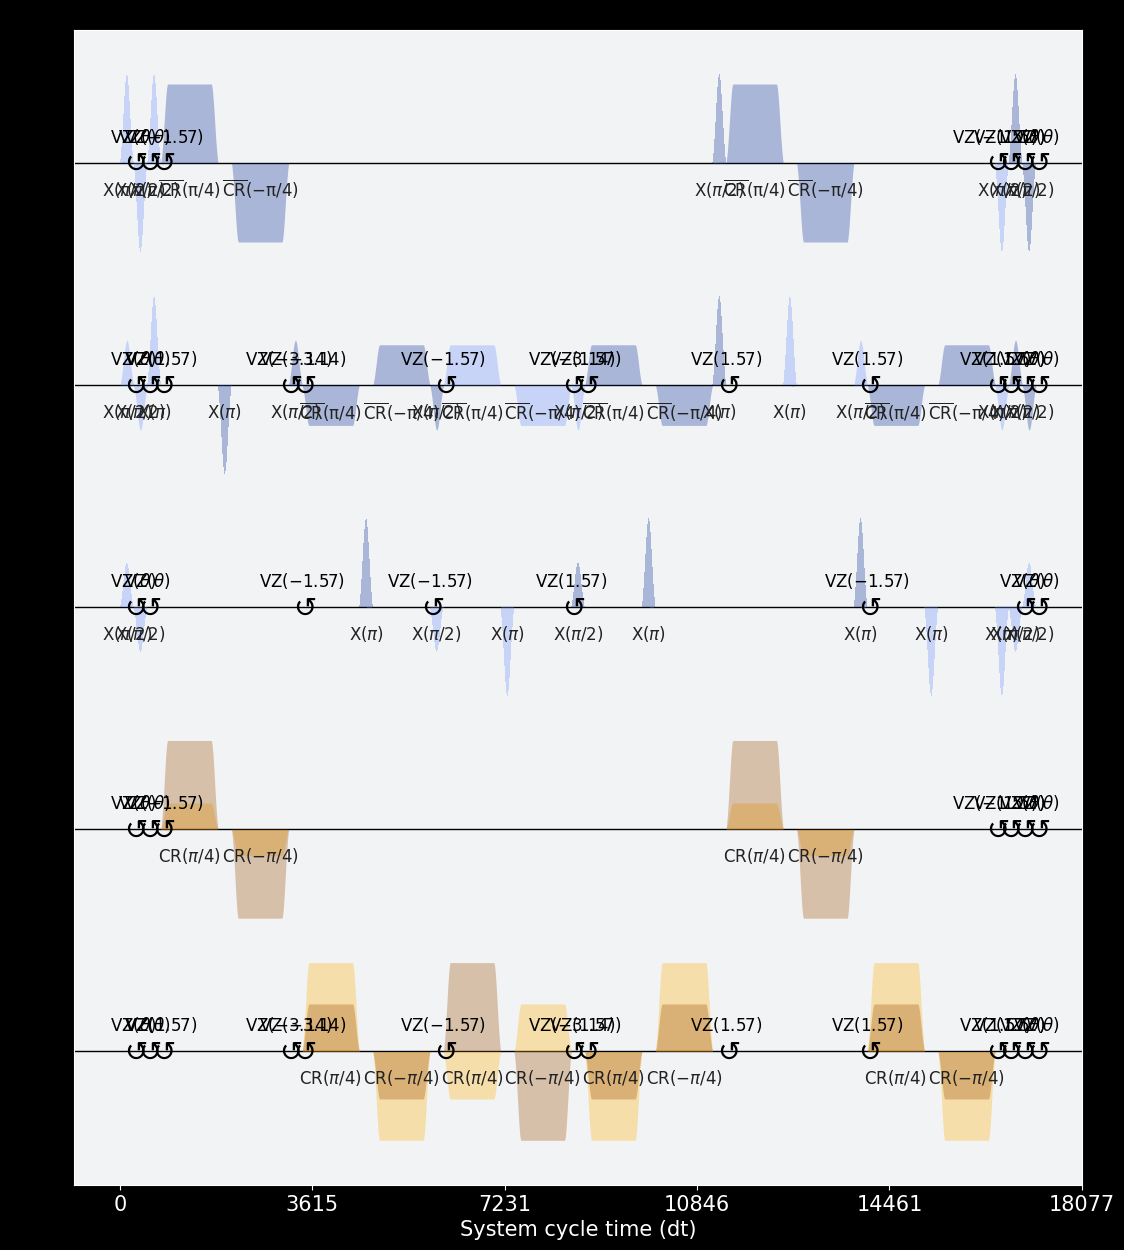

In [23]:
from qiskit import schedule
pulse_schedule = schedule(isa_circuit,backend_answer)
pulse_schedule.draw()

In [22]:
# backend.configuration().basis_gates


## implementing The Quantum Utility paper

## implementing VQClassifier 

## transpiling the circuit and pulse scheduling

## hardware option of IBM and the pulse produced by it. 